In [1]:
!pip install datasets transformers albumentations huggingface_hub

In [ ]:
# NEW ALGO #

"""
to deal with inconsistently labelled data
we will train our model on the original data
then we will use the output maps from this model
and combine them with original maps using (logical OR)
then re-train and check results

another idea is to not always use the combined maps...
if we can figure out a way to know the cases in which old maps have inconsistencies
then only in those cases we add Logical-OR

Options: (LOR is logical OR)
1. model1 ka loss 1.0 se zyada aya matlab usme inconsistency ho sakti hai... to tab logical-OR karo...otherwise use the labels as is
2. sab me LOR karo
3. agar model1 me loss 0.1 se kam hai then logical or mat karo... 0.1 indicates that model has learnt to classify that sample almost perfectly.

"""

'\nto deal with inconsistently labelled data\nwe will train our model on the original data\nthen we will use the output maps from this model\nand combine them with original maps using (logical OR)\nthen re-train and check results\n\n'

In [2]:
from datasets import load_dataset

dataset = load_dataset("jaygala223/38-cloud-train-only-v2")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/jaygala223--38-cloud-train-only-v2-8694e732c8608fcc/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8400
    })
})

In [ ]:
# # exclude bad labels

# bad_labels = [35, 36]

# dataset['train'] = dataset['train'].select(
#     (
#         i for i in range(dataset['train'].num_rows)
#         if i not in set(bad_labels)
#     )
# )

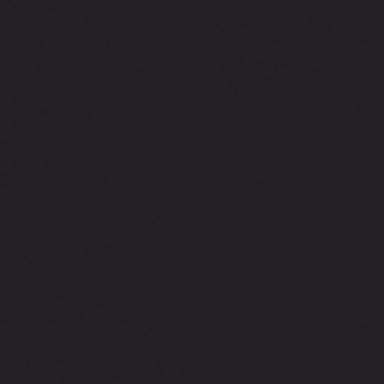

In [4]:
dataset['train'][2500]['image']

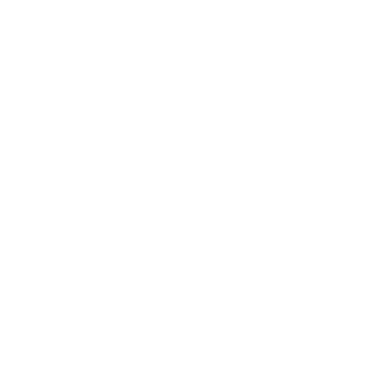

In [5]:
dataset['train'][2500]['label']

In [6]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.01)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [7]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 8316
})
Dataset({
    features: ['image', 'label'],
    num_rows: 84
})


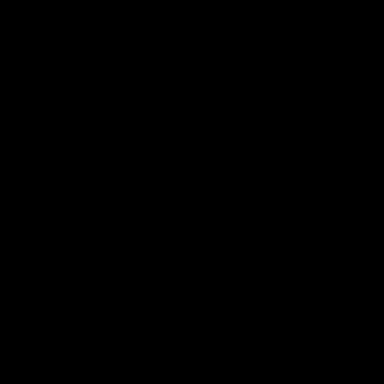

In [8]:
# let's look at one example
example = train_ds[39]
image = example['image']
image

In [9]:
import numpy as np
np.array(image).shape

(384, 384, 3)

In [10]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])/255
segmentation_map = np.array(segmentation_map, dtype=np.uint8)
segmentation_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
np.unique(segmentation_map)

array([0], dtype=uint8)

In [12]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"jaygala223/38-cloud-train-only-v2"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'non-cloud', 1: 'cloud'}


In [13]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    # return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
    #         [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
    #         [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
    #         [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
    #         [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
    #         [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
    #         [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
    #         [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
    #         [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
    #         [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
    #         [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
    #         [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
    #         [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
    #         [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
    #         [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
    #         [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
    #         [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
    #         [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
    #         [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
    #         [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
    #         [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
    #         [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
    #         [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
    #         [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
    #         [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
    #         [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
    #         [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
    #         [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
    #         [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
    #         [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
    #         [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
    #         [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
    #         [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
    #         [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
    #         [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
    #         [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
    #         [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
    #         [102, 255, 0], [92, 0, 255]]

    #since we only have 2 classes
    return [[102, 255, 0], [92, 0, 255]]

palette = color_palette()

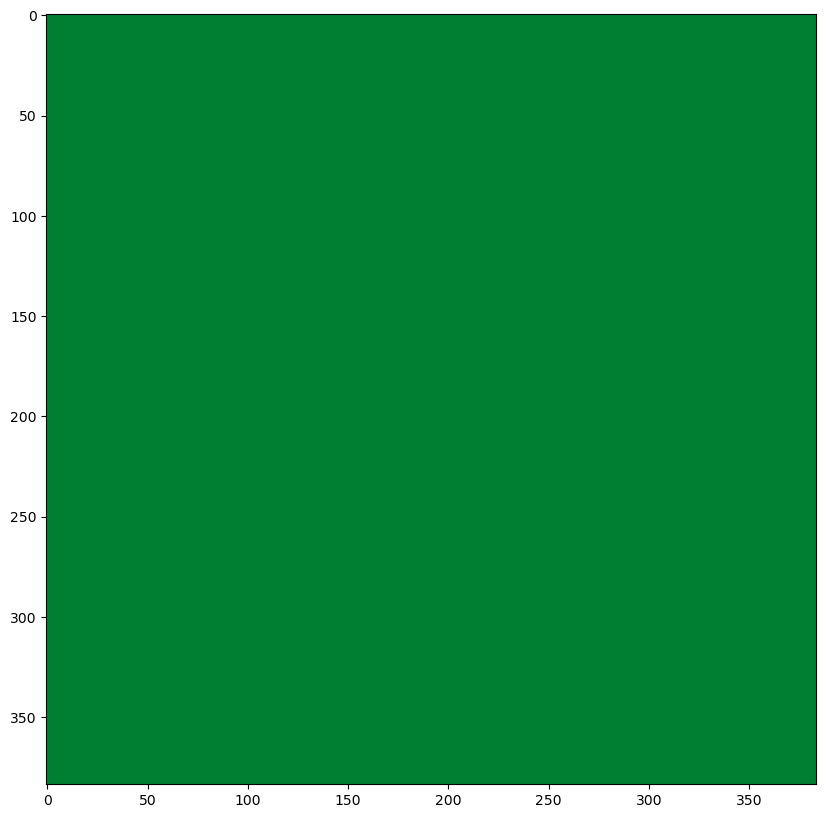

In [14]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [15]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        # adding one bottom most pixel as 255 since processor/feature_extractor
        # wont take labels without a positive (i.e. class: 1 or cloud)
        uniques = np.unique(original_segmentation_map)
        if sum(uniques) == 0:
            original_segmentation_map[-1, -1] = 255

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [16]:
import albumentations as A


ADE_MEAN = np.array([100, 100, 100]) / 255
ADE_STD = np.array([100, 100, 100]) / 255

train_transform = A.Compose([
    # A.LongestMaxSize(max_size=384),
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    # A.Resize(width=100, height=100),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# train_dataset = ImageSegmentationDataset(train_ds)
train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)
# test_dataset = ImageSegmentationDataset(test_ds)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
# image, segmentation_map, _, _ = train_dataset[0]
image, segmentation_map, _, _ = train_dataset[222]
print(image.shape)
print(segmentation_map.shape)

(3, 384, 384)
(384, 384)


In [18]:
from transformers import MaskFormerImageProcessor,Mask2FormerImageProcessor, AutoImageProcessor

# Create a preprocessor
# preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                   do_reduce_labels=False,
#                                                   do_resize=False, do_rescale=False, do_normalize=False)

size = {'longest_edge':384, 'shortest_edge':384}

#original
preprocessor = MaskFormerImageProcessor(ignore_index=0,
                                        do_reduce_labels=False,
                                        do_resize=False,
                                        do_rescale=False,
                                        do_normalize=True,
                                        size=size)

#my experiment
# preprocessor = Mask2FormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [19]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

In [20]:

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# batch size more than 4 causes CUDA out of memory error

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [22]:
import torch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):

    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 384, 384])
pixel_mask torch.Size([2, 384, 384])
mask_labels torch.Size([1, 384, 384])
class_labels torch.Size([1])
original_images (384, 384, 3)
original_segmentation_maps (384, 384)


In [23]:
from transformers import MaskFormerForInstanceSegmentation, Mask2FormerForUniversalSegmentation

# Replace the head of the pre-trained model

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic",
#                                                             id2label=id2label,
#                                                             ignore_mismatched_sizes=True)


from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-ade-semantic",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# model = MaskFormerForInstanceSegmentation.from_pretrained("jaygala223/maskformer-finetuned-for-38-cloud-dataset",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

In [35]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation, AutoImageProcessor, UperNetForSemanticSegmentation
from PIL import Image
import requests

size = {'longest_edge':384, 'shortest_edge':383}

# load MaskFormer fine-tuned on COCO panoptic segmentation
# feature_extractor = Mask2FormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-ade",
#                                                                size=size,
#                                                                )

# model 1 is for generating new pred segmentation maps... model 2 is to train on new pred labels

image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-tiny")
model1 = UperNetForSemanticSegmentation.from_pretrained("jaygala223/upernet-swin-tiny-finetuned-for-38-cloud-dataset")
model2 = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-tiny")

In [36]:
import torch
device = "cuda"
batch = next(iter(train_dataloader))

images, labels = batch['original_images'], batch['original_segmentation_maps']

# first convert to np array then to tensor... because list to tensor is a slow operation
images = np.array(images)
images = torch.tensor(images)/255
labels = np.array(labels)
labels = torch.tensor(labels)/255

images.to(device)
labels.to(device)
model1.to(device)
model2.to(device)

inputs1 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')
# print(inputs)
# for item in inputs['mask_labels']:
#     print(item.shape)

# inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
# inputs['class_labels'] = torch.stack(inputs['class_labels'])

# inputs['pixel_values'] = inputs['pixel_values'].float()

inputs1.to(device)

# print(labels.shape)

outputs1 = model1(**inputs1)

target_sizes1 = [(image.shape[0], image.shape[1]) for image in images]

predicted_segmentation_maps1 = image_processor.post_process_semantic_segmentation(outputs1,
                                                                                  target_sizes=target_sizes1)

images = images


if outputs1.loss.item() >= 0.8: # if loss from finetuned model is huge then label may have inconsistencies
  labels = torch.logical_or(labels.to(device), torch.stack(predicted_segmentation_maps1).to(device)) # generate new labels using OR

inputs2 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

inputs2.to(device)

# train on new labels to tackle label inconsistency
outputs2 = model2(**inputs2)

# if outputs1.loss.item() <= 0.15:
#     outputs2 = outputs1

print("done!")

done!


In [37]:
print(outputs1.loss)
print(outputs2.loss)

tensor(1.9976, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5253, device='cuda:0', grad_fn=<AddBackward0>)


TRAINING

In [38]:
# UPER NET with new LOGICAL OR technique

import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cuda"
model1.to(device)
model2.to(device)

optimizer = torch.optim.Adam(model2.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

running_loss = 0.0
num_samples = 0

for epoch in range(3):
  print("Epoch:", epoch)
  model2.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)

      # forward pass

      inputs1 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs1.to(device)

      outputs1 = model1(**inputs1)

      target_sizes1 = [(image.shape[0], image.shape[1]) for image in images]

      predicted_segmentation_maps1 = image_processor.post_process_semantic_segmentation(outputs1,
                                                                                        target_sizes=target_sizes1)

      images = images

#       # generate new labels using OR
#       labels = torch.logical_or(labels.to(device), torch.stack(predicted_segmentation_maps1).to(device))

      if outputs1.loss.item() >= 0.8: # if loss from finetuned model is huge then label may have inconsistencies
        labels = torch.logical_or(labels.to(device), torch.stack(predicted_segmentation_maps1).to(device)) # generate new labels using OR


      inputs2 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs2.to(device)

      # train on new labels to tackle label inconsistency
      outputs2 = model2(**inputs2)

#       if outputs1.loss.item() <= 0.10:
#             outputs2 = outputs1

      # Backward propagation
      loss = outputs2.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 50 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

#       scheduler.step()

Epoch: 0


  0%|          | 0/4158 [00:00<?, ?it/s]

Loss: 1.189470887184143
Loss: 1.3708996176719666
Loss: 1.0595062491622302
Loss: 0.906054200172819
Loss: 0.8084482024632283
Loss: 0.7296090595038288
Loss: 0.6640051308264368
Loss: 0.6298966294425166
Loss: 0.5916531985843939
Loss: 0.5672459746205027
Loss: 0.5364523929192456
Loss: 0.5044467122971795
Loss: 0.4935054153532484
Loss: 0.4760376022736644
Loss: 0.4689729348404304
Loss: 0.4578162554363793
Loss: 0.44058210188557817
Loss: 0.42930906565069765
Loss: 0.41751412297604185
Loss: 0.4072149323561982
Loss: 0.39661406475834765
Loss: 0.3898871569122435
Loss: 0.38485820644148555
Loss: 0.3741679133727603
Loss: 0.3682174237094491
Loss: 0.3627460607023036
Loss: 0.3529912238707229
Loss: 0.3471200360029351
Loss: 0.34131937298051573
Loss: 0.3354559830151791
Loss: 0.32997449148610125
Loss: 0.32675302053335153
Loss: 0.32171456401453336
Loss: 0.31867595040676566
Loss: 0.3132872393281954
Loss: 0.3105324825321429
Loss: 0.30797875936798286
Loss: 0.3052165780781488
Loss: 0.30088356606096917
Loss: 0.2978094

  0%|          | 0/4158 [00:00<?, ?it/s]

Loss: 0.226251739042449
Loss: 0.2247821898162002
Loss: 0.22352533076314052
Loss: 0.22210759548820516
Loss: 0.22110716199603195
Loss: 0.21994890420279178
Loss: 0.21860808336843715
Loss: 0.21785344768717907
Loss: 0.21710185078417024
Loss: 0.2163649192569912
Loss: 0.2154687559331065
Loss: 0.21450320379349708
Loss: 0.21410299359550133
Loss: 0.2129648443394534
Loss: 0.21233493415197965
Loss: 0.2111368998817805
Loss: 0.20996475959103536
Loss: 0.20959631411729088
Loss: 0.2088045265618914
Loss: 0.2058882624588986
Loss: 0.20476570597688923
Loss: 0.20424868437406116
Loss: 0.20396196177603948
Loss: 0.20349285995040411
Loss: 0.2026205056016958
Loss: 0.20186586404185092
Loss: 0.2008315197548788
Loss: 0.19963927108881346
Loss: 0.19892151640561068
Loss: 0.1981325423957712
Loss: 0.19720392523607264
Loss: 0.19634400168338412
Loss: 0.19579217717123062
Loss: 0.1950048939789092
Loss: 0.19427733494517968
Loss: 0.19392648832604287
Loss: 0.19310000106151265
Loss: 0.19232474701279628
Loss: 0.191456582092094
L

  0%|          | 0/4158 [00:00<?, ?it/s]

Loss: 0.17161494945492844
Loss: 0.17117765517079997
Loss: 0.1707938631689299
Loss: 0.1703977169232456
Loss: 0.16992846290741453
Loss: 0.16937649315091013
Loss: 0.1690335444767686
Loss: 0.16856322911059934
Loss: 0.16799739990795254
Loss: 0.16744551941107297
Loss: 0.16677568343782148
Loss: 0.16644676518447957
Loss: 0.16602011793883165
Loss: 0.1655389915000098
Loss: 0.165228938414164
Loss: 0.16467465725139846
Loss: 0.16410234372187302
Loss: 0.16365811991388693
Loss: 0.16328490941464563
Loss: 0.16276422542216562
Loss: 0.16220859896012885
Loss: 0.1619501003559406
Loss: 0.1618998905709242
Loss: 0.16172200952065527
Loss: 0.16159704266653954
Loss: 0.16130499932976788
Loss: 0.16149180480026273
Loss: 0.1612207682909392
Loss: 0.16097152213741592
Loss: 0.16077439740610175
Loss: 0.1603781210562988
Loss: 0.15994472244600205
Loss: 0.15955464851989812
Loss: 0.15938400399311556
Loss: 0.15891730268093957
Loss: 0.1586340561219476
Loss: 0.15845426388407635
Loss: 0.1581550190537425
Loss: 0.1578988213111413

In [ ]:
import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cuda"
model1.to(device)
model2.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-9)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

running_loss = 0.0
num_samples = 0
for epoch in range(1):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)

#       inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#       print(inputs)

      # UPER NET TINY
      # inputs = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      # UPER NET TINY

#       inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
      # comment the mask labels and class labels for segformer
#       inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
#       inputs['class_labels'] = torch.stack(inputs['class_labels'])
      # comment the mask labels and class labels for segformer

#       inputs['pixel_values'] = inputs['pixel_values'].float()
      # inputs.to(device)

      # outputs = model(**inputs)

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 50 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

#       scheduler.step()

Epoch: 0


  0%|          | 0/4158 [00:00<?, ?it/s]

Loss: 0.15979760885238647

Loss: 0.055722007600992336

Loss: 0.06555868521111437

Loss: 0.0683302745802809

Loss: 0.07045274599228259

Loss: 0.07108875591515663

Loss: 0.07116940762983802

Loss: 0.07196800433300923

Loss: 0.07115603786918737

Loss: 0.07202088099154758

Loss: 0.07035374725349024

Loss: 0.07224220690484785

Loss: 0.07146401131624812

Loss: 0.07119912233778752

Loss: 0.07050936658017752

Loss: 0.07263780275630094

Loss: 0.07209392496327707

Loss: 0.0718220066925955

Loss: 0.07200786000123861

Loss: 0.07263111094155836

Loss: 0.0729698621305999


KeyboardInterrupt: ignored

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
repo_name = "upernet-swin-tiny-finetuned-for-38-cloud-dataset"
model2.push_to_hub(repo_name)

pytorch_model.bin:   0%|          | 0.00/240M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jaygala223/upernet-swin-tiny-finetuned-for-38-cloud-dataset/commit/8ae544b092632cedc3e8df05efbc590da2ec6f62', commit_message='Upload UperNetForSemanticSegmentation', commit_description='', oid='8ae544b092632cedc3e8df05efbc590da2ec6f62', pr_url=None, pr_revision=None, pr_num=None)

TESTING

In [30]:
def calculate_iou(pred_mask_list, true_mask_list):
    total_iou = 0.0
    num_masks = len(pred_mask_list)

    for pred_mask, true_mask in zip(pred_mask_list, true_mask_list):
        pred_mask = pred_mask.cpu()
        true_mask = true_mask.cpu()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()

        iou = intersection.float() / union.float()
        total_iou += iou.item()

    avg_iou = total_iou / num_masks
    return avg_iou

In [31]:
import torch

def calculate_metrics(true_labels, predicted_labels, device):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for true, predicted in zip(true_labels, predicted_labels):
        true.to(device)
        predicted.to(device)
        true_positives += torch.sum((predicted == 1) & (true == 1)).item()
        false_positives += torch.sum((predicted == 1) & (true == 0)).item()
        false_negatives += torch.sum((predicted == 0) & (true == 1)).item()
        true_negatives += torch.sum((predicted == 0) & (true == 0)).item()

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, accuracy, f1_score

# Example usage
true_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]
predicted_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]

precision, recall, accuracy, f1_score = calculate_metrics(true_labels, predicted_labels, "cuda")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

Precision: 0.9999999750000006
Recall: 0.9999999750000006
Accuracy: 0.9999999833333336
F1 Score: 0.9999999250000032


In [40]:
# UPERNET evaluation WITH NEW ALGO: LOGICAL OR

from tqdm.auto import tqdm

model2.eval()
device = "cpu"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 10:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model1.to(device)
    model2.to(device)


    # Forward pass
    with torch.no_grad():
      # forward pass

      inputs1 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs1.to(device)

      outputs1 = model1(**inputs1)

      target_sizes1 = [(image.shape[0], image.shape[1]) for image in images]

      predicted_segmentation_maps1 = image_processor.post_process_semantic_segmentation(outputs1,
                                                                                        target_sizes=target_sizes1)

      images = images

      if outputs1.loss.item() >= 0.8: # if loss from finetuned model is huge then label may have inconsistencies
        labels = torch.logical_or(labels.to(device), torch.stack(predicted_segmentation_maps1).to(device)) # generate new labels using OR

      inputs2 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs2.to(device)

      # train on new labels to tackle label inconsistency
      outputs2 = model2(**inputs2)

#       if outputs1.loss.item() <= 0.10:
#             outputs2 = outputs1

    # get original images
    # original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs2,
                                                                                  target_sizes=target_sizes)

#     print(outputs.keys())
    # get ground truth segmentation maps
    # ground_truth_segmentation_maps = batch["original_segmentation_maps"]
    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)

#     print(predicted_segmentation_maps)
#     print(labels)

    # removing all values into a list of ints because the evaluate library expects it that way.
    labels_for_evaluation = []

    for label in labels:
        labels_for_evaluation.append(label.view(-1))

    labels_for_evaluation = torch.cat(labels_for_evaluation, dim = 0)
    labels_for_evaluation.int()

    pred_labels_for_evaluation = []

    for preds in predicted_segmentation_maps:
        pred_labels_for_evaluation.append(label.view(-1))

    pred_labels_for_evaluation = torch.cat(pred_labels_for_evaluation, dim = 0)
    pred_labels_for_evaluation.int()

    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i])

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/42 [00:00<?, ?it/s]

precision 0.778883770028171
f1_score 0.738424662669732
recall 0.7107555593271003
accuracy 0.9711710611975874
mIoU:  0.45576837387951935


In [33]:
from tqdm.auto import tqdm

model2.eval()
device = "cpu"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 10:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model2.to(device)

    ### Upernet
    inputs = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    ### upernet

#     inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#     print(inputs)

    ##### comment these 2 lines for segformer... keep otherwise ####
#     inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
#     inputs['class_labels'] = torch.stack(inputs['class_labels'])
    ##### comment these 2 lines for segformer... keep otherwise ####
#     inputs['pixel_values'] = inputs['pixel_values'].float()
    inputs.to(device)

    # Forward pass
    with torch.no_grad():
      # outputs = model(pixel_values=pixel_values.to(device))
      outputs = model2(**inputs)

    # get original images
    # original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

#     print(outputs.keys())
    # get ground truth segmentation maps
    # ground_truth_segmentation_maps = batch["original_segmentation_maps"]
    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)

#     print(predicted_segmentation_maps)
#     print(labels)

    # removing all values into a list of ints because the evaluate library expects it that way.
    labels_for_evaluation = []

    for label in labels:
        labels_for_evaluation.append(label.view(-1))

    labels_for_evaluation = torch.cat(labels_for_evaluation, dim = 0)
    labels_for_evaluation.int()

    pred_labels_for_evaluation = []

    for preds in predicted_segmentation_maps:
        pred_labels_for_evaluation.append(label.view(-1))

    pred_labels_for_evaluation = torch.cat(pred_labels_for_evaluation, dim = 0)
    pred_labels_for_evaluation.int()

    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i])

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/42 [00:00<?, ?it/s]

precision 0.736419133891274
f1_score 0.6018209047100102
recall 0.5604275861728594
accuracy 0.890780053957242
mIoU:  0.3308566889979623


In [ ]:
# upernet-swin tiny (tuned)
precision 0.9392357746591729
f1_score 0.8274812357961276
recall 0.8020496805250736
accuracy 0.9476910215432391
mIoU:  0.4426152956756679

# upernet-swin tiny (tuned)
precision 0.8683672456144808
f1_score 0.7479758424948
recall 0.7284804817339592
accuracy 0.9722921968707247
mIoU:  0.5187820670279589

# Upernet with LOGICAL OR (OR applied in both training and testing)
precision 0.8958519725202133
f1_score 0.8624015916309787
recall 0.8332964487274218
accuracy 0.9741602425620118
mIoU:  0.5371215126731179

At 20% training loss
precision 0.8409011146308205
f1_score 0.8532656625558744
recall 0.8737207014226013
accuracy 0.9673955127443059
mIoU:  0.4893365881659768

At 12% training loss
precision 0.8699746802445684
f1_score 0.8642844356050445
recall 0.8592141353492534
accuracy 0.9738575328476813
mIoU:  0.5058126130395315

At 8% training loss
precision 0.8674168711460868
f1_score 0.8635056062496748
recall 0.8602445691426681
accuracy 0.9734111747353077
mIoU:  0.5060400659726425


# Upernet with LOGICAL OR TWICE(OR applied in both training and testing)
at 40% training loss
precision 0.8800218235572824
f1_score 0.8670481177351661
recall 0.8570141818017505
accuracy 0.9781614361383997
mIoU:  0.512333486567844


# Upernet with LOGICAL OR (OR applied only in training and not in testing)
At 20% training loss
precision 0.8056717629325668
f1_score 0.8335686847209157
recall 0.8731451883300031
accuracy 0.9480223992855058
mIoU:  0.467702101577412

At 12% training loss
precision 0.8366282128662313
f1_score 0.8486793148867103
recall 0.8624495891429831
accuracy 0.9583616931025791
mIoU:  0.4875807930630716


# upernet swin large (untuned)
precision 0.04674390520428237
f1_score 0.05677240963341936
recall 0.07227933222051418
accuracy 0.1463044294935711
mIoU:  0.33444785990053044

#maskformer tuned
precision 0.7754642685034004
f1_score 0.7528422777953474
recall 0.7397811585765738
accuracy 0.9775063871126577
mIoU:  0.7168471569364722

precision 0.5217402294425123
f1_score 0.5894180085336521
recall 0.999999981816197
accuracy 0.5217402294425123
mIoU:  0.521740224174788

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3241 in run_cell_async  │
│                                                                                                  │
│   3238 │   │   │   with self.display_trap:                                                       │
│   3239 │   │   │   │   # Compile to bytecode                                                     │
│   3240 │   │   │   │   try:                                                                      │
│ ❱ 3241 │   │   │   │   │   code_ast = compiler.ast_parse(cell, filename=cell_name)               │
│   3242 │   │   │   │   except self.custom_exceptions as e:                                       │
│   3243 │   │   │   │   │   etype, value, tb = sys.exc_info()                                     │
│   3244 │   │   │   │   │   self.CustomTB(etype, value, tb)                                       │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/IPython/core/compilerop.py:86 in ast_parse               │
│                                                                                                  │
│    83 │   │                                                                                      │
│    84 │   │   Arguments are exactly the same as ast.parse (in the standard library),             │
│    85 │   │   and are passed to the built-in compile function."""                                │
│ ❱  86 │   │   return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)            │
│    87 │                                                                                          │
│    88 │   def reset_compiler_flags(self):                                                        │
│    89 │   │   """Reset compiler flags to default state."""                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ precision 0.807980100402321                                                                      │
│           ▲                                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: invalid syntax

* precision 0.3111225918183273
* f1_score 0.3191659886291905
* recall 0.3295510091217397
* accuracy 0.9829524113575062
* mIoU:  0.29805679046190703

* precision 0.26088595055841357
* f1_score 0.29013017962476445
* recall 0.3274049580908574
* accuracy 0.988511827256274
* mIoU:  0.25725841522216797

